Classifying handwritten digits (work in progress!!)
-----
The MNIST dataset contains **labelled images of handwritten digits** - one common machine learning exercise
is to use this dataset to train a model to recognise digits. In this write-up we will see why - it's
a difficult task with impressive results!

In the course of implementing a few models to accomplish this task,
we'll take a look at **hyperparameter tuning**,
and some basic methods for **reducing the dimensionality** of the dataset.

Why would we want to reduce the dimensionality of our dataset? Surely losing data is a bad thing?
There are two primary reasons. One is **robustness to overfitting** - if we can drop
some of the noise without losing signal, we will improve the generality of our model.
Another reason is the practicalities of training, providing the model with a smaller dataset
should lead to **faster training convergence** (is this true? I'm not sure it is...)

Models
-----
We will compare the following models in terms of both accuracy and speed.
1. **MLPClassifier**, a multi-layer perceptron. We will use a simple neural net with only one hidden layer.
2. **XGBoost**, a **extremely?** gradient boosted ensemble of decision trees **?**
    * https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/
    * It definitely has impressive CPU usage on my laptop!
3. **LinearSVC**, a support vector classifier with a linear kernel.
4. **GradientBoostingClassifier**, a gradient boosted ensemble of decision trees **?**

Confidence checking
-----
A large fraction of the time spent learning a new tool is actually spent
learning to debug that tool!
When the model doesn't do what we expect, we need to know what to check.
In the spirit of that, we will implement
some of the confidence checks mentioned in the excellent blog post
https://karpathy.github.io/2019/04/25/recipe/
.
* **Randomised labels** - How does our model behave when the labels are randomised? This dataset will be all noise and no signal, so will be a measure of the ability of our model to overfit the data. 
* **The loss curve** - How does the loss evolve as the model trains? Does it decrease, as it should? Any large spikes from outlier batches?
* **Purposeful overfitting** - If we train our small datasets we should be able to fit it perfectly. We won't do this, though. How should we feel about the fact our training score is 100%?
* **Visualising features** - Understanding the edges/features picked up by the network, the preprocessing.

Metrics
----
We will use sklearn.metrics.accuracy_score as our metric.
This is the fraction of the samples that were correctly classified. 

Any quoted times will be as measured on my laptop - note these timings are not meant to be rigorous comparisons!

Preprocessing
------
1. **None** - This dataset is small enough that we can just train on all the data. How well does this work, does it overfit on the noise?
2. **Random** - If we randomise the labels, can the model achieve a good score on the training set?
3. **Principal component analysis** - PCA extracts the features that explain the majority of the variance, how well do these features function as predictors for the digits? 
4. **Legendre decomposition** - We can expand the pixel image in a two-dimensional Legendre polynomial basis. How well do the coefficients of this expansion function as predictors? Unlike PCA, this basis is not decided by the basis set. This may reduce its predictive ability, but should also increase robustness to noise. Why Legendre polynomials? Because I have experience with them from my PhD.

There are multiple important differences between PCA features and Legendre coefficient features.
For one thing, the PCA will converge to a perfect reconstruction of the image as the number of components approaches the dimension of the data,
whereas the Legendre decomposition will not - the Legendre decomposition will be especially bad at reconstructing sharp edges.
However, **the processed features do not actually have to be good at reconstructing the original features** - it just has to preserve the information that distinguishes the digits.

To do
-----
* **Simplify** - move anything unnec to Bonus, or cut.
* Why doesn't full PCA match no preproc result?
* Lower max_iter for rand case
* Visualise what Legendre can do that PCA can't
* Implement K-fold cross-validation
* What is the state of the art for MNIST?
* Unsupervised MNIST, how many real classes? (Do eg kmeans, increasing the number of clusters, print Counter of each cluster.)
* Interpret confusion matrix, score(s), loss curve, epoch vs iteration (does it use all the data?)
* How should we feel about the fact our training score is 100%?
* Fourier basis? Read the literature.

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import matplotlib.pyplot as plt
from numpy.random import permutation
from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
from scipy.integrate import quad
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy.special import eval_legendre
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from time import time
from collections import Counter
from IPython.display import display
np.random.seed(42)
pd.options.display.float_format = '{:.3f}'.format

In [2]:
name = 'mnist_784'
mnist = fetch_openml(name, data_home='~/scikit_learn_data/openml/'+name)
N1 = 28

Let's see what kind of data we're dealing with! We'll plot the images of the first few digits, and check the count of the labels.

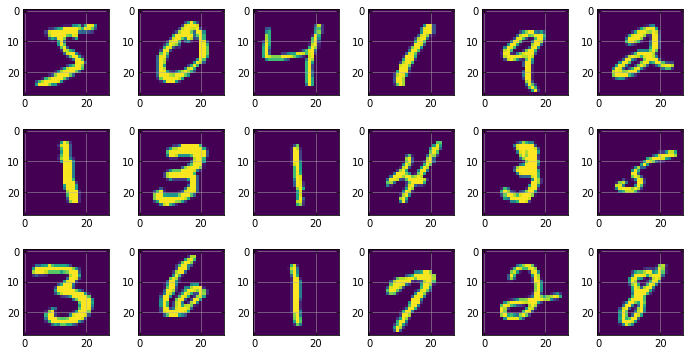

Max: 255.0
Min: 0.0
Shape: (70000, 784)
Labels and counts: Counter({'1': 7877, '7': 7293, '3': 7141, '2': 6990, '9': 6958, '0': 6903, '6': 6876, '8': 6825, '4': 6824, '5': 6313})


In [3]:
fig, axs = plt.subplots(3,6,figsize=(12,6))
axs = axs.flatten()
N_plot = len(axs)
for i in range(N_plot):
    axs[i].imshow(mnist.data.values[i].reshape((N1,N1)))
plt.show()
print('Max:', np.max(mnist.data.values))
print('Min:', np.min(mnist.data.values))
print('Shape:', np.shape(mnist.data.values))
print('Labels and counts:', Counter(mnist['target']))

The dataset consists of 70000 greyscale images. The images are encoded as 28 by 28 pixels, taking values between 0 and 255. The labels are characters representing the digits 0 to 9, and we can see that there are **roughly equal counts for each label** in the dataset - there are more 1's and fewer 5's, but the counts are all around 7000.

Let's split up the dataset for training and testing. Two sets won't suffice, however - we'll also need a set for hyperparameter tuning, which we'll call the validation set.
We'll split the dataset up into a **training set** with half the data, and a **validation set** and **test set** with a quarter of the data each.
The hyperparameters we'll tune are the features that are fed into the model.
The validation set cannot give us a true estimate of the error, since it will be biased to seem
more accurate than it actually is.
When we evaluate the score on the test set for each model, at the very end, that will give us an
**estimate of the error** of the model.

In [4]:
X = mnist['data'].values
y = mnist['target']
test_size = 0.5
X_train, X_nottrain, y_train, y_nottrain = train_test_split(X, y, test_size=test_size, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_nottrain, y_nottrain, test_size=0.5, random_state=43)
for grp in [X_train, X_valid, X_test]:
    print(np.shape(grp))
for grp in [y_train, y_valid, y_test]:
    print('Labels and counts:', Counter(grp))

(35000, 784)
(17500, 784)
(17500, 784)
Labels and counts: Counter({'1': 3950, '3': 3590, '7': 3575, '4': 3491, '8': 3481, '2': 3470, '9': 3448, '0': 3440, '6': 3386, '5': 3169})
Labels and counts: Counter({'1': 1947, '7': 1816, '9': 1801, '6': 1786, '2': 1785, '3': 1771, '0': 1732, '8': 1638, '4': 1628, '5': 1596})
Labels and counts: Counter({'1': 1980, '7': 1902, '3': 1780, '2': 1735, '0': 1731, '9': 1709, '8': 1706, '4': 1705, '6': 1704, '5': 1548})


The main model we'll test is a basic MLP with a **single hidden layer with 120 nodes**. We'll use dectified linear units (ReLU's) as activation functions. We choose our learning rate to be 1e-4, to give us nice loss curves later.

In [5]:
tol = 1e-2

hidden_layer_sizes = [120]
method_name, method = 'mlp', MLPClassifier
method_params = {'hidden_layer_sizes':hidden_layer_sizes, 'activation':'relu', 'random_state':16, 'tol':tol, 'learning_rate_init':1e-4, 'max_iter':4000}

N_samples_cut = {LinearSVC.__name__:10000, XGBClassifier.__name__:3500, GradientBoostingClassifier.__name__:500}
other_methods = [XGBClassifier, LinearSVC, GradientBoostingClassifier]#, SVC]
other_params = dict()
other_params[LinearSVC.__name__] = {'max_iter':4000, 'dual':False, 'tol':tol}
XGB_early_stopping_rounds = 10
other_params[XGBClassifier.__name__] = {'use_label_encoder':False, "objective":"multi:softmax","num_class":10, "eval_metric":"mlogloss"}
## # n_iter_no_change needs to be set!
other_params[GradientBoostingClassifier.__name__] = {'tol':tol}

# https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html
# "max_iter: int, default=200
# Maximum number of iterations. The solver iterates until convergence (determined by ‘tol’) or this number of iterations.
# For stochastic solvers (‘sgd’, ‘adam’), note that this determines the number of epochs
# (how many times each data point will be used), not the number of gradient steps."

We'll use **PCA** to pick out a set of features which should hopefully capture the data well. This will help by reducing the noise, making the model more robust to overfitting.

In [6]:
pca_results = []
display_cols = ['Features','Validation score','Train score','Time taken [s]']
## # This is a bit innefficient as the PCA need only be done once,
## # and the first n_components taken at each iteration
## # (but this way lets us use the pipeline set-up).
for sqrt_n_components in range(8,29,5):
    n_components = sqrt_n_components**2
    t1 = time()
    pca = PCA(n_components=n_components, random_state=42)
    pca_pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca), (method_name, method(**method_params))])
    pca_pipe.fit(X_train, y_train)
    t2 = time()
    
    score_valid = accuracy_score(y_valid, pca_pipe.predict(X_valid))
    score_train = accuracy_score(y_train, pca_pipe.predict(X_train))
    pca_results.append([n_components, score_valid, score_train, t2-t1])
    print(n_components, end='\t')
    #print(n_components, score_valid, score_train, t2-t1, sep='\t', flush=True)
print('')
pca_results = np.array(pca_results)
pd.DataFrame(pca_results, columns=display_cols)

64	169	324	529	784	


,Features,Validation score,Train score,Time taken [s]
0,64.000,0.942,0.950,30.030
1,169.000,0.947,0.960,28.620
2,324.000,0.950,0.970,43.110
3,529.000,0.948,0.976,46.975
4,784.000,0.948,0.982,61.250


That's pretty good! The training score is perfect, but the one that really matters is the validation score, which peaks around 97.1%
with around 150 features.
This means that the model is correctly labelling 97.1% of the 17,500 validation samples correctly,
and so has not suffered too much from overfitting.

Let's examine the **confusion matrix** and **loss curve** for the model with 784 features.

[0.97690531 0.98202363 0.93557423 0.92377188 0.94963145 0.93796992
 0.9675252  0.94933921 0.93040293 0.92615214]


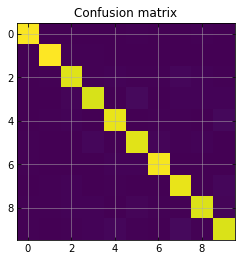

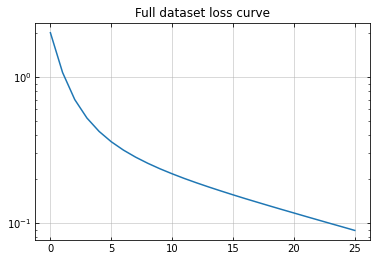

In [7]:
con = confusion_matrix(y_valid, pca_pipe.predict(X_valid), normalize='true')
print(np.diag(con))
plt.imshow(con)
plt.title('Confusion matrix')
plt.show()
#for a in con:
#    for b in a:
#        print(round(b,3), end='\t')
#    print('')
plt.plot(pca_pipe[method_name].loss_curve_)
plt.title('Full dataset loss curve')
plt.yscale('log')
plt.show()

The confusion matrix seems pretty even, it doesn't look like the model is concentrating too much on any particular digit.
The loss curve is smooth, giving us some hope that we have chosen our learning rate correctly.

What if we train the same MLP using the **full dataset**, without applying any dimensional reduction?

In [8]:
## # Full
n_components = X_valid.shape[1]
#print(n_components)
t1 = time()
full_pipe = Pipeline([('scaler', StandardScaler()), (method_name, method(**method_params))])
full_pipe.fit(X_train, y_train)
t2 = time()
score_valid = accuracy_score(y_valid, full_pipe.predict(X_valid))
score_train = accuracy_score(y_train, full_pipe.predict(X_train))
full_result = [n_components, score_valid, score_train, t2-t1]
#print('Features\tValidation score\tTrain score\tTime taken [s]')
#print(n_components, score_valid, score_train, t2-t1, sep='\t', flush=True)
display_cols = ['Features','Validation score','Train score','Time taken [s]']
pd.DataFrame([full_result], columns=display_cols)

,Features,Validation score,Train score,Time taken [s]
0,784,0.957,0.980,33.981


**Why is full nearly as good as the peak? Does the score vs N_features plot have multiple peaks?**

Let's compare **XGBClassifier**, **LinearSVC** and **GradientBoostingClassifier**.
The latter two are quite slow in comparison with the MLP, so **we will only train on a subset of the data**.

In [9]:
other_results = []
for mthd in other_methods:
    n_components = X_valid.shape[1]
    t1 = time()
    #print(np.shape(X_train[:100,:100]))
    mthd_pipe = Pipeline([('scaler', StandardScaler()), (mthd.__name__, mthd(**other_params[mthd.__name__]))])
    cut = N_samples_cut[mthd.__name__]
    print(f'Using {cut} training samples for {mthd.__name__}.', flush=True)
    #print(X_train[:cut][:10].sum())
    #print(y_train[:cut][:10].values)
    if mthd.__name__=='XGBClassifier':
        label_encoder = LabelEncoder()
        label_encoder = label_encoder.fit(y_train[:cut].astype("category"))
        #fit_dict = {'XGBClassifier__early_stopping_rounds':XGB_early_stopping_rounds}
        mthd_pipe.fit(X_train[:cut], label_encoder.transform(y_train[:cut].astype("category")))#, **fit_dict)
    else:
        mthd_pipe.fit(X_train[:cut], y_train[:cut])
    t2 = time()
    #print(mthd_pipe.predict(X_valid[:10]))
    #print(y_valid[:10].values)
    score_valid, score_train = 0., 0.
    if mthd.__name__=='XGBClassifier':
        score_valid = accuracy_score(label_encoder.transform(y_valid[:cut]), mthd_pipe.predict(X_valid[:cut]))
        score_train = accuracy_score(label_encoder.transform(y_train[:cut]), mthd_pipe.predict(X_train[:cut]))
    else:
        score_valid = accuracy_score(y_valid[:cut], mthd_pipe.predict(X_valid[:cut]))
        score_train = accuracy_score(y_train[:cut], mthd_pipe.predict(X_train[:cut]))
    other_results.append([mthd.__name__, cut, score_valid, score_train, t2-t1])
    #print(mthd.__name__, cut, score_valid, score_train, round((t2-t1),2), sep='\t', flush=True)#'''
"""XGBClassifier	10000	0.9529	1.0	80.43"""
"""XGBClassifier	30000	0.9730857142857143	1.0	258.93
LinearSVC	10000	0.8603	0.9772	49.94
GradientBoostingClassifier	5000	0.919	0.9992	212.92"""
display_cols = ['Method name','Samples','Validation score','Train score','Time taken [s]']
pd.DataFrame(other_results, columns=display_cols)

Using 3500 training samples for XGBClassifier.
Using 10000 training samples for LinearSVC.
Using 500 training samples for GradientBoostingClassifier.


,Method name,Samples,Validation score,Train score,Time taken [s]
0,XGBClassifier,3500,0.928,1.000,52.101
1,LinearSVC,10000,0.875,0.972,29.641
2,GradientBoostingClassifier,500,0.774,1.000,20.304


Wow, XGBClassifier is impressive! It is a little bit slower than the MLP took to train,
but the result is slightly better, at 97.3% vs 97.1%.

What if we train the same MLP using the full dataset, with the target **labels randomly permuted**?
There should be **no signal** here, the entire training set should be noise.
If our model can achieve a good training score, that would mean our model is capable of extremely overfitting the data.
By comparing with this example, we can have confidence that when using the correctly labelled data,
our model is **really learning** something.

In [10]:
## # Random (no signal, all noise)
n_components = X_valid.shape[1]
#print(n_components)
t1 = time()
rand_pipe = Pipeline([('scaler', StandardScaler()), (method_name, method(**method_params))])
permed_train = permutation(y_train)
rand_pipe.fit(X_train, permed_train)
t2 = time()
score_valid = accuracy_score(y_valid, rand_pipe.predict(X_valid))
score_train = accuracy_score(permed_train, rand_pipe.predict(X_train))
rand_result = [n_components, score_valid, score_train, t2-t1]
display_cols = ['Features','Validation score','Train score','Time taken [s]']
#print(n_components, score_valid, score_train, t2-t1, sep='\t', flush=True)
pd.DataFrame([rand_result], columns=display_cols)

,Features,Validation score,Train score,Time taken [s]
0,784,0.115,0.225,28.156


The training score of 73.1% is due to the ability of the model to overfit the data. As expected, the validation score is around 10%,
reflecting the even distribution of the ten classes in the training and validation sets - **the model is essentially guessing**.

Best result:
Features	Validation score	Train score	Time taken [s]
784	0.095	0.924	3382.621

Let's try using the coefficients of a **2D Legendre decomposition** as features for our model.

In [11]:
N_pixel=28
breaks = np.linspace(-1,1,N_pixel+1,endpoint=True)
centers = np.array([np.mean(breaks[i:i+2]) for i in range(N_pixel)])

Q = np.zeros((N_pixel, N_pixel))
for n in range(N_pixel):
    for i in range(N_pixel):
        Q[n,i] = quad(lambda x,n=n:eval_legendre(n, x)*np.sqrt(n+0.5), breaks[i], breaks[i+1], epsabs=1.49e-08, epsrel=1.49e-08, limit=50)[0]

leg_features_sq = []
X_train_sq = X_train.reshape((-1,28,28))
X_valid_sq = X_valid.reshape((-1,28,28))
for to_fit in X_train_sq:
    coeffs_full = np.einsum('ia,ba->ib', Q, to_fit)
    coeffs_full = np.einsum('jb,ib->ij', Q, coeffs_full)
    leg_features_sq.append(coeffs_full)

leg_results = []
#print('Features\tValidation score\tTrain score\tTime taken [s]')
for Nmax in range(8,29,5):
    t1 = time()
    ## # Converting pixel features to Legendre features,
    ## # reducing dimensionality and smoothing.
    ## # Training set:
    leg_features = np.array([cs[:Nmax,:Nmax].flatten() for cs in leg_features_sq])
    
    ## # Fitting the model
    leg_pipe = Pipeline([('scaler', StandardScaler()), (method_name, method(**method_params))])
    leg_pipe.fit(leg_features, y_train)
    t2 = time()
    
    ## # Validation set:
    leg_valid = []
    for to_fit in X_valid_sq:
        coeffs = np.einsum('ia,ba->ib', Q[:Nmax], to_fit)
        coeffs = np.einsum('jb,ib->ij', Q[:Nmax], coeffs)
        leg_valid.append(coeffs.flatten())
    leg_valid = np.array(leg_valid)
    score_valid = accuracy_score(y_valid, leg_pipe.predict(leg_valid))
    score_train = accuracy_score(y_train, leg_pipe.predict(leg_features))
    leg_results.append([Nmax**2, score_valid, score_train, t2-t1])
    #print(Nmax**2, score_valid, score_train, t2-t1, sep='\t', flush=True)
    print(Nmax**2, end='\t')
print('')
display_cols = ['Features','Validation score','Train score','Time taken [s]']
pd.DataFrame(leg_results, columns=display_cols)

64	169	324	529	784	


,Features,Validation score,Train score,Time taken [s]
0,64,0.936,0.940,13.455
1,169,0.958,0.965,15.787
2,324,0.963,0.975,23.099
3,529,0.958,0.983,27.808
4,784,0.952,0.991,38.985


By eye, the scores and times for Legendre preprocessing seem similar to the PCA case.

Let's compare them properly, by plotting the scores and times as we increase the numbers of features.
We'll also plot the loss curves for PCA and Legendre preprocessing with 784 features.

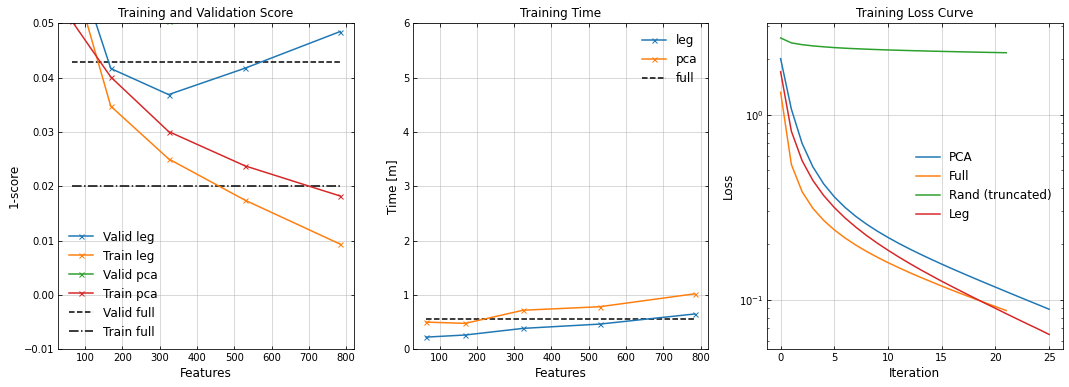

Final value of rand loss: 22 iterations gives loss=2.16.


In [12]:
fig, axs = plt.subplots(1, 3, figsize=(18,6))
axs[0].plot([r[0] for r in leg_results], [1-r[1] for r in leg_results], '-x', label='Valid leg')
axs[0].plot([r[0] for r in leg_results], [1-r[2] for r in leg_results], '-x', label='Train leg')
axs[1].plot([r[0] for r in leg_results], [r[3]/60 for r in leg_results], '-x', label='leg')
axs[0].plot([r[0] for r in pca_results], [1-r[1] for r in pca_results], '-x', label='Valid pca')
axs[0].plot([r[0] for r in pca_results], [1-r[2] for r in pca_results], '-x', label='Train pca')
axs[1].plot([r[0] for r in pca_results], [r[3]/60 for r in pca_results], '-x', label='pca')
xmin, xmax = min(pca_results[:,0]), max(pca_results[:,0])
axs[0].hlines(1-full_result[1], xmin, xmax, linestyles='--', label='Valid full')
axs[0].hlines(1-full_result[2], xmin, xmax, linestyles='-.', label='Train full')
axs[1].hlines(full_result[3]/60, xmin, xmax, linestyles='--', label='full')
axs[2].plot(pca_pipe[method_name].loss_curve_, '-', label='PCA')
axs[2].plot(full_pipe[method_name].loss_curve_, '-', label='Full')
axs[2].plot(rand_pipe[method_name].loss_curve_[:len(leg_pipe[method_name].loss_curve_)], '-', label='Rand (truncated)')
axs[2].plot(leg_pipe[method_name].loss_curve_, '-', label='Leg')
axs[2].set_yscale('log')
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[0].set_title('Training and Validation Score')
axs[1].set_title('Training Time')
axs[2].set_title('Training Loss Curve')
axs[0].set_xlabel('Features')
axs[0].set_ylabel('1-score')
axs[1].set_xlabel('Features')
axs[1].set_ylabel('Time [m]')
axs[2].set_ylabel('Loss')
axs[2].set_xlabel('Iteration')
axs[0].set_ylim(-0.01, 0.05)
axs[1].set_ylim(0, 6.)
plt.show()
print(f"Final value of rand loss: {len(rand_pipe[method_name].loss_curve_)} iterations gives loss={round(rand_pipe[method_name].loss_curve_[-1],2)}.")

The validation score curves show us that the Legendre features are more **robust to overfitting**,
as it stays good with a larger number of features **QUANTIFY**.
**Spikes in the loss curves** are due to having a learning rate that is too large.
We have reduced our learning rate here to **1e-4** to remove these spikes, which are due to an **outlier minibatch**.
**PCA and Legendre curves don't match the full result. We only go up to 21X21 features.**
The plots show there is **no significant difference in time taken to train**,
though this isn't a totally fair comparison - the PCA is being performed for every iteration of the loop, when in reality it
only needs to be performed once, and the first n components taken.

Using all the features leads to overfitting. PCA helps, but since the features are picked based on variance they might not actually hold the cluster information. Legendre coefficients as features cut out noise, but can also make use of more features before giving in to overfitting, hence achieve a better validation score (though the difference is only marginal, 97.7% compared to 97.1%).

What about training our other models (XGBClassifier, LinearSVC, GradientBoostingClassifier) on the Legendre features,
with Nmax=13?

In [13]:
X_train_sq = X_train.reshape((-1,28,28))
X_valid_sq = X_valid.reshape((-1,28,28))
Nmax = 13
## # Converting pixel features to Legendre features,
## # reducing dimensionality and smoothing.
## # Training set:
leg_train = []
for to_fit in X_train_sq:
    coeffs = np.einsum('ia,ba->ib', Q[:Nmax], to_fit)
    coeffs = np.einsum('jb,ib->ij', Q[:Nmax], coeffs)
    leg_train.append(coeffs.flatten())
leg_train = np.array(leg_train)

## # Validation set:
leg_valid = []
for to_fit in X_valid_sq:
    coeffs = np.einsum('ia,ba->ib', Q[:Nmax], to_fit)
    coeffs = np.einsum('jb,ib->ij', Q[:Nmax], coeffs)
    leg_valid.append(coeffs.flatten())
leg_valid = np.array(leg_valid)
    
#######

leg_other_results = []
#print(XGBClassifier.score.__name__)
for mthd in other_methods:
    n_components = leg_valid.shape[1]
    mthd_pipe = Pipeline([('scaler', StandardScaler()), (mthd.__name__, mthd(**other_params[mthd.__name__]))])
    cut = N_samples_cut[mthd.__name__]
    t1 = time()
    if mthd.__name__=='XGBClassifier':
        label_encoder = LabelEncoder()
        label_encoder = label_encoder.fit(y_train[:cut].astype("category"))
        mthd_pipe.fit(leg_train[:cut], label_encoder.transform(y_train[:cut].astype("category")))
    else:
        mthd_pipe.fit(leg_train[:cut], y_train[:cut])
    t2 = time()
    score_valid, score_train = 0., 0.
    if mthd.__name__=='XGBClassifier':
        score_valid = accuracy_score(label_encoder.transform(y_valid[:cut]), mthd_pipe.predict(leg_valid[:cut]))
        score_train = accuracy_score(label_encoder.transform(y_train[:cut]), mthd_pipe.predict(leg_train[:cut]))
    else:
        score_valid = accuracy_score(y_valid[:cut], mthd_pipe.predict(leg_valid[:cut]))
        score_train = accuracy_score(y_train[:cut], mthd_pipe.predict(leg_train[:cut]))
    leg_other_results.append([mthd.__name__, cut, score_valid, score_train, t2-t1])
    #print(mthd.__name__, cut, score_valid, score_train, round((t2-t1),2), sep='\t', flush=True)
"""With no preprocessing:
XGBClassifier	30000	0.9730857142857143	1.0	258.93
LinearSVC	10000	0.8603	0.9772	49.94
GradientBoostingClassifier	5000	0.919	0.9992	212.92"""
display_cols = ['Method name', 'Samples', 'Validation score', 'Training score', 'Time taken']
pd.DataFrame(leg_other_results, columns=display_cols)

,Method name,Samples,Validation score,Training score,Time taken
0,XGBClassifier,3500,0.928,1.000,27.522
1,LinearSVC,10000,0.907,0.926,8.703
2,GradientBoostingClassifier,500,0.822,1.000,38.835


The training scores are slightly lower here for LinearSVC and GradientBoostingClassifier.
The GradientBoostingClassifier has a slightly higher validation score, at 91.8% vs 91.6%,
but the LinearSVC has seen a drastic improvement at 90.7% vs 86.0%.
XGBClassifier has performed slightly worse, at 96.9% vs 97.3%.

**Compare loss curves?**

Using the Legendre expansion coefficients as features has proven to be at least as successful as using PCA,
and more successful in the case of LinearSVC. We can assign this success to their robustness to noise,
as the lower order terms in the expansion will only pick up on large features in the image.

We could also give more general orthogonal polynomials a try, for example polynomials orthogonal to some weight function on the space. This possibly already exists in the literature. We won't explore it any further here, though.

Grand finale
-----
To state something incredibly obvious, the accuracy score on the training set is not going to be a good estimate for the model's accuracy on unseen data, as this is the data the model was, well, trained on.
Similarly, the accuracy score on the validation set won't be a good estimate of the error on unseen data either - this is the set
we used to choose our hyperparameters, so the error will be biased to be smaller than the true error.
This is why we have kept a quarter of our data locked away up until now. Now that all our tuning is done
we can finally apply our model to that data and estimate the true error rate of the model.
Once we've seen this, we can't tune our model any further and still have an honest estimate of our error rate, so we better be sure we're ready!

1. MLP, with Leg_opt and full.
2. XGBClassifier, with Leg_opt and full.
3. LinearSVC, with Leg_opt and full.
4. GradientBoostingClassifier, with Leg_opt and full.

Bonus - visualising the processed features
---

How well do the Legendre/PCA decompositions capture the image?
Recall that the processed features do not actually have to be able to reconstruct the image perfectly,
as they only need sufficient infomation to distinguish between the digits. In fact, it is
preferable if they can't reconstruct the noise!
Still, let's take a look at what the features actually look like.

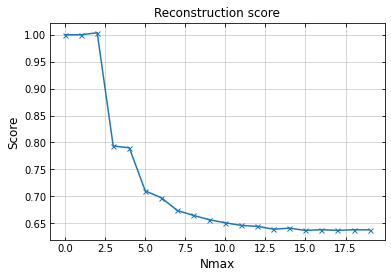

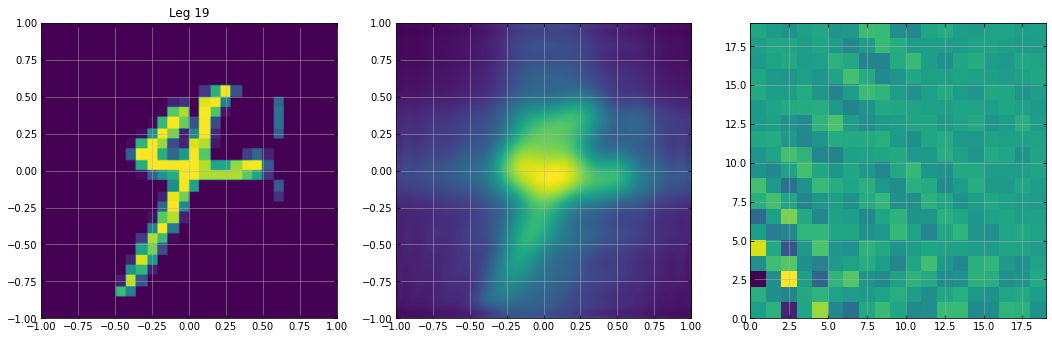

0	1	2	3	4	5	6	7	8	9	10	11	12	13	14	15	16	17	18	19	20	21	22	23	24	25	26	27	28	


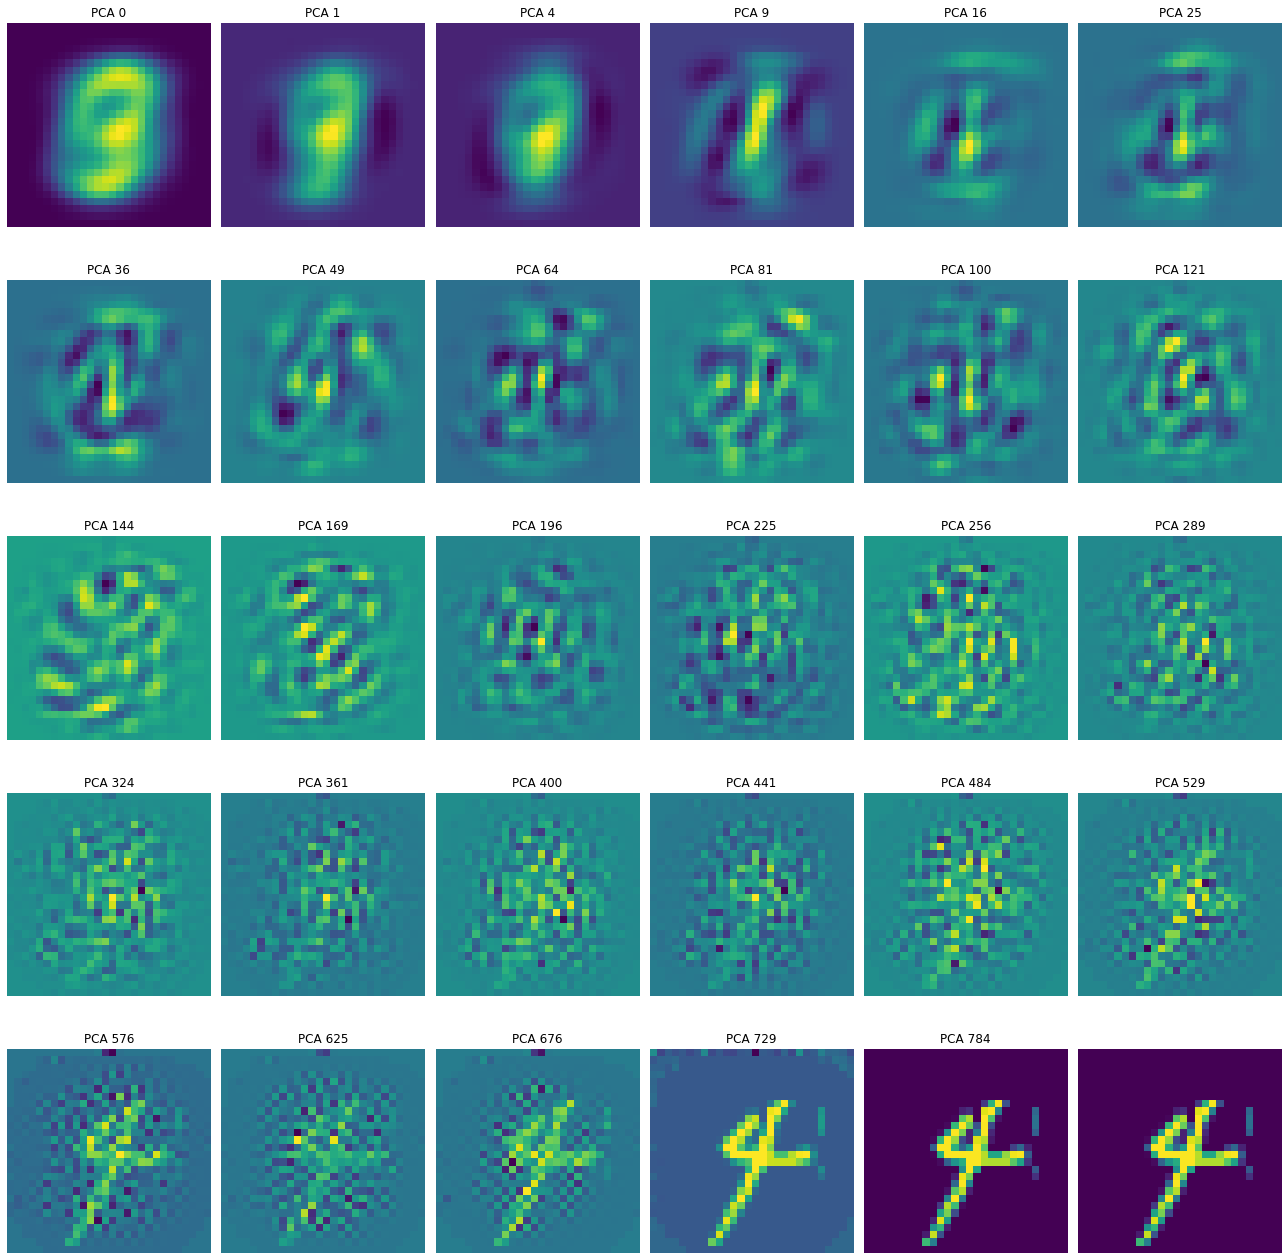

In [14]:
## # 2d
N_pixel = 28
breaks = np.linspace(-1,1,N_pixel+1,endpoint=True)
centers = np.array([np.mean(breaks[i:i+2]) for i in range(N_pixel)])
mnist_ind = 53
## # Careful to copy, not view!
to_fit = np.copy(mnist['data'].values[mnist_ind].reshape((28,28)))
to_fit -= to_fit.mean()
to_fit = to_fit/to_fit.std()
#to_fit = np.clip(to_fit, 0, 255)
#print(breaks)
def func(x, y):
    x = np.clip(np.ceil((1+x)*N_pixel/2), 0, 27)
    y = np.clip(np.ceil((1+y)*N_pixel/2), 0, 27)
    temp = to_fit[y.astype(np.int64), x.astype(np.int64)]
    return temp

N_plot = 150
xs = np.linspace(-1, 1, N_plot, endpoint=True)
ys = np.linspace(-1, 1, N_plot, endpoint=True)
f_xs, f_ys = np.meshgrid(xs, ys)[0].flatten(), np.meshgrid(xs, ys)[1].flatten()
fns = func(f_xs, f_ys)
#fig, ax = plt.subplots(1, 1, figsize=(12,6))
#ax.imshow(fns.reshape((N_plot, N_plot)), label='real', extent=[-1, 1, -1, 1])
#plt.show()

N = 101
## # We should already have this from above?
Q = np.zeros((N_pixel, N_pixel))
for n in range(N_pixel):
    for i in range(N_pixel):
        Q[n,i] = quad(lambda x,n=n:eval_legendre(n, x)*np.sqrt(n+0.5), breaks[i], breaks[i+1], epsabs=1.49e-08, epsrel=1.49e-08, limit=50)[0]
recon_res = []
for Nmax in range(20):#range(1,32,10):
    coeffs = np.einsum('ia,ba->ib', Q[:Nmax], to_fit)
    coeffs = np.einsum('jb,ib->ij', Q[:Nmax], coeffs)
    #print(np.shape(coeffs))       
    N_plot = 150
    xs = np.linspace(-1, 1, N_plot, endpoint=True)
    ys = np.linspace(-1, 1, N_plot, endpoint=True)
    f_xs, f_ys = np.meshgrid(xs, ys)[0].flatten(), np.meshgrid(xs, ys)[1].flatten()
    fns = func(f_xs, f_ys)
    recomp = np.dot(coeffs, [eval_legendre(n, xs) for n in range(Nmax)])
    #print(1, np.shape(recomp))
    recomp = np.dot(recomp.T, [eval_legendre(n, xs) for n in range(Nmax)]).flatten()
    #print(2, np.shape(recomp))
    recon_res.append([Nmax, np.sum((recomp-fns)**2)/np.sum(fns**2)])
recon_res = np.array(recon_res)
#print('\n',np.sum(coeffs**2))
plt.title('Reconstruction score')
plt.plot(recon_res[:,0], recon_res[:,1], '-x')
plt.ylabel('Score')
plt.xlabel('Nmax')
plt.show()
fig, axs = plt.subplots(1, 3, figsize=(18,6))
axs[0].set_title(f'Leg {Nmax}')
axs[0].imshow(fns.reshape((N_plot, N_plot)), label='real', extent=[-1, 1, -1, 1])
axs[1].imshow(recomp.reshape((N_plot, N_plot)), label='recomp', extent=[-1, 1, -1, 1])
axs[2].imshow(coeffs[::-1,:], extent=[0, Nmax, 0, Nmax])
plt.show()
########################
fig, axs = plt.subplots(5, 6, figsize=(18,18))
axs = axs.flatten()
for sqrt_n_components in range(1, 29, 2):
    ## # Don't need to retrain the pipe every time, just use the first n.
    pca = PCA(n_components=sqrt_n_components**2, random_state=42)
    pca_only_pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
    pca_only_pipe.fit(X_train)
    pca_fit = pca_only_pipe.transform(to_fit.reshape((1,-1)))
    pca_inv_fit = pca_only_pipe.inverse_transform(pca_fit).reshape((28,28))
    #fig, axs = plt.subplots(1, 3, figsize=(18,6))
    axs[sqrt_n_components].set_title(f'PCA {sqrt_n_components**2}')
    #axs[0].imshow(to_fit, label='real', extent=[-1, 1, -1, 1])
    axs[sqrt_n_components].imshow(pca_inv_fit, label='recomp', extent=[-1, 1, -1, 1])
    #axs[2].imshow(pca_fit.reshape((28,28))[::-1,:], extent=[0, Nmax, 0, Nmax])
    print(sqrt_n_components, end='\t', flush=True)
    axs[sqrt_n_components].axis('off')
print('')
axs[-1].axis('off')
axs[-1].imshow(to_fit, label='recomp', extent=[-1, 1, -1, 1])
plt.tight_layout()
plt.show()

What does the distribution of coefficients look like?

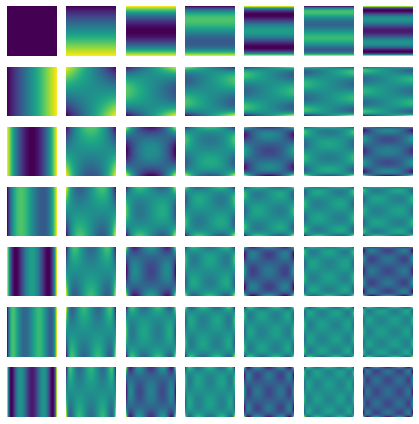

In [15]:
#print(coeffs[:3,:3])
#print(coeffs[-3:,-3:])
N_plot = 101
ps = np.linspace(-1, 1, N_plot, endpoint=True)
xs, ys = np.meshgrid(ps, ps)[0].flatten(), np.meshgrid(ps, ps)[1].flatten()
Nmax_plot = 7
fig, axs = plt.subplots(Nmax_plot, Nmax_plot, figsize=(6,6))
for n1 in range(Nmax_plot):
    temp = eval_legendre(n1, xs)*np.sqrt(n1+0.5)
    for n2 in range(Nmax_plot):
        temp2 = temp*eval_legendre(n2, ys)*np.sqrt(n2+0.5)
        #axs[n1][n2].set_title(f'{n1}, {n2}')
        axs[n1][n2].imshow(temp2.reshape((N_plot,N_plot)))
        axs[n1][n2].axis('off')
plt.tight_layout()
plt.show()